In [33]:
import rasterio
from netCDF4 import Dataset
from rasterio import Affine as A
import numpy as np
from os import listdir, makedirs
from os.path import isfile, join, basename, exists
import xarray
from rasterio.transform import from_origin
import matplotlib.pyplot as plt
import rioxarray as riox
import traceback

In [34]:
# input the directory and the program will parse all netcdf geodata
EARTH_RADIUS = 6371000.0
KM_NEG_2TOM_NEG_2 = 10**-6
DAYS_TO_SECONDS = 60 * 60 * 24
INIT_YEAR = 1850
KM_TO_M = 10**6


dir_path = input("[*] Please enter the directory path to the file: ")
save_folder_path = join(dir_path, "upscale")
gfed5_variable_names = ["Crop", "Defo", "Peat", "Total"]
scaling_size_height = int(input("[*] Please enter the height of the new scale: "))
scaling_size_width = int(input("[*] Please enter the width of the new scale: "))
new_shape = (scaling_size_height, scaling_size_width)
files =  [
    join(dir_path, file)
    for file in listdir(dir_path)
    if isfile(join(dir_path, file))
    and (file.split(".")[-1] == "hdf5" or file.split(".")[-1] == "nc")
]

In [35]:
def upscale_matrix_numpy(source_matrix, window_height = 8, window_width = 10):
    """
    Function preforms the process of upscaling the passed in matrix using numpy or skimage
    (first determining if this is possible and then preforming the operation)
    
    :param source_matrix: matrix we wish to compress (upscale)
    :param window_height: height of the window we wish to iterate over with
    :param window_width: width of the window we wish to iterate over with
    :return: upscaled matrix
    """
    
    try:
        source_shape = source_matrix.shape   
        # check if the window size lines up evenly with the passed in matrix
        if (source_shape[0] % window_height == 0) and (source_shape[1] % window_width == 0):
            # This is another method to reduce a matrix with a window using a sum calculation (both work the same)
            # downscaled_data = block_reduce(source_matrix, block_size=(window_height, window_width), func=np.sum)
            # reshape the matrix into a 4D matrix (shows each window of the matrix)
            reshape_result = source_matrix.reshape(source_shape[0] // window_height, window_height, source_shape[1] // window_width, window_width)
            # sum the windows and creates the 2D matrix
            result = reshape_result.sum(axis=(1, 3))
            print("[+] Successfully upscaled matrix, current updated matrix shape: ", np.asarray(result).shape)
            return result
    except Exception as error:
        print("[-] Failed to upscale matrix", error)
        return source_matrix

In [36]:
def calculate_grid_area(grid_area_shape):
    bound_position = 0.25
    height, width = grid_area_shape
    latitudes = np.linspace(-90, 90, height)
    longitudes = np.linspace(-180, 180, width)

    diffs_lat = np.diff(latitudes)
    diffs_lon = np.diff(longitudes)

    diffs_lat = np.insert(diffs_lat, 0, diffs_lat[0])
    diffs_lat = np.append(diffs_lat, diffs_lat[-1])

    diffs_lon = np.insert(diffs_lon, 0, diffs_lon[0])
    diffs_lon = np.append(diffs_lon, diffs_lon[-1])

    min_bounds = latitudes - diffs_lat[:-1] * bound_position
    max_bounds = latitudes + diffs_lat[1:] * (1 - bound_position)
    lat1d = np.array([min_bounds, max_bounds]).transpose()

    min_bounds = longitudes - diffs_lon[:-1] * bound_position
    max_bounds = longitudes + diffs_lon[1:] * (1 - bound_position)
    lon1d = np.array([min_bounds, max_bounds]).transpose()

    lon_bounds_radian = np.deg2rad((lon1d))
    lat_bounds_radian = np.deg2rad((lat1d))

    radius_sqr = EARTH_RADIUS**2
    radian_lat_64 = lat_bounds_radian.astype(np.float64)
    radian_lon_64 = lon_bounds_radian.astype(np.float64)

    ylen = np.sin(radian_lat_64[:, 1]) - np.sin(radian_lat_64[:, 0])
    xlen = radian_lon_64[:, 1] - radian_lon_64[:, 0]
    areas = radius_sqr * np.outer(ylen, xlen)
    return np.abs(areas)

In [37]:
def create_geotiff_file(data_arr, latitude_arr, longitude_arr):
    """
    Creates a new geotif file to be used for resampling or displaying data on the map

    :param data_arr: numpy array containing the geo data
    :param latitude_arr: numpy array representing the latitude
    :param longitude_arr: numpy array representing the longitude
    :return: geotiff file path
    """
    # obtain the data_arr shape
    height, width = data_arr.shape
    # create a transformation of the data to match a global map
    transform = from_origin(
        longitude_arr[0],
        latitude_arr[-1],
        abs(longitude_arr[1] - longitude_arr[0]),
        abs(latitude_arr[-1] - latitude_arr[-2]),
    )
    
    # outline meta data about the geotiff file
    metadata = {
        "driver": "GTiff",
        "count": 1,
        "dtype": "float32",
        "width": width,
        "height": height,
        "crs": "EPSG:3857", # optional formats EPSG:3857 (works on panoply) EPSG:4326 (works well on leaflet)
        "transform": transform,
    }

    # obtain the GeoTIFF path
    geotiff_file_path = join(save_folder_path, "output.tif")
    # Create a new GeoTIFF file using the crafted path and add the data to the file 
    with rasterio.open(geotiff_file_path, "w", **metadata) as dst:
        # total_data_value = np.flip(data_arr, 0)
        dst.write(data_arr, 1)
    # return the GeoTIFF file path
    return geotiff_file_path

In [38]:
def upscale_matrix_restario(source_matrix, dest_dimensions):
        """
        Function preforms the process of upscaling the passed in matrix using rasterio and geotiff

        :param source_matrix: matrix we wish to compress (upscale)
        :param dest_dimensions: a tuple/list containing the dimensions you want to transform the matrix
        :return: reshaped numpy matrix
        """
        # https://github.com/corteva/rioxarray/discussions/332
        #Obtain the numpy array shape
        height, width = source_matrix.shape
        # create a long and latitude numpy array
        latitude_arr = np.linspace(-90, 90, height)
        longitude_arr = np.linspace(-180, 180, width)
        
        # create the geotiff file and return the path to that file
        geotiff_file_path = create_geotiff_file(
            source_matrix, latitude_arr, longitude_arr
        )
        
        #open that newly created geotiff file
        raster = riox.open_rasterio(geotiff_file_path)

        # preform upsampling using rasterio and rioxarray
        up_sampled = raster.rio.reproject(
            raster.rio.crs,
            shape=(int(dest_dimensions[0]), int(dest_dimensions[1])),
            resampling=rasterio.warp.Resampling.sum,
        )
        
        # obtain the data
        data_value = up_sampled.values[0]
        # close the file (script will yell at you if you dont)
        raster.close()
        # return numpy data array
        return data_value

In [39]:
def evaluate_upscale_sum(origin_matrix, upscaled_matrix, margin_of_error = 65536.0):
    """
    Function prints our the original matrix sum and the upscaled matrix sum (post re grid)
    It then determines if the upscaled matrix sum is close enough to the original matrix sum (incorporating a margin of error)
    
    :param origin_matrix: original matrix before re grid
    :param upscaled_matrix: the original matrix post re grid
    :param margin_of_error: the margin of error the allowed 
    :return: boolean
    """
    print()
    print(f"Original Burned Area Total - {origin_matrix.sum()}")
    print(f"\tOriginal Burned Area Dimensions - {origin_matrix.shape}")
    print(f"\tOriginal Burned Area Mean - {origin_matrix.mean()}")
    print(f"Upscale Burned Area Total - {upscaled_matrix.sum()}")
    print(f"\tUpscale Burned Area Dimensions - {upscaled_matrix.shape}")
    print(f"\tUpscale Burned Area Mean - {origin_matrix.mean()}")
    print()
    
    # returns true if the upscaled matrix sum is within the range of the original matrix sum (margin of error accounts for rounding of values)
    return upscaled_matrix.sum() >= (origin_matrix.sum() - margin_of_error) and upscaled_matrix.sum() <= (origin_matrix.sum() + margin_of_error)
    

In [40]:
def obtain_new_filename(file_path) -> str:
    # creates a file name (adding upscale to the current file name)
    file_name = basename(file_path)
    file_name_list = file_name.split(".")
    if len(file_name_list) > 1:
        file_name_list[-2] = file_name_list[-2] + "(upscaled)"
        # ensures the file is saved as a netcdf file
        file_name_list[-1] = "nc"
        # return the rejoined list and the added classes save folder path
        return join(save_folder_path, ".".join(file_name_list))
    return join(save_folder_path, file_name)

In [41]:
def save_file(file_path, data_set) -> None:
    """
    Saves the xarray dataset based on the file inputted to the function

    :param file_path: file path of the current file being upscaled/processed
    :param data_set: data set representing the
    :return: None
    """
    try:
        # create the new file's path & name
        new_file_name = obtain_new_filename(file_path)
        # checks if the save folder path exists (if it does not a folder is created)
        if not exists(save_folder_path):
            makedirs(save_folder_path)
        # saves the file using the created file path and xarray
        data_set.to_netcdf(path=(new_file_name))
        print(f"[+] file {new_file_name} saved")
    except Exception as error:
        print(
            "[-] Failed to save dataset (ensure dataset is from xarray lib): ",
            error,
        )

In [42]:
def plot_geodata(origin_matrix, upscaled_matrix, longitude, latitude) -> None:
    """
    Saves the xarray dataset based on the file inputted to the function
    
    :param file_path: file path of the current file being upscaled/processed 
    :param data_set: data set representing the 
    :return: None
    """
    # map = Basemap(projection='merc',llcrnrlon=-90.,llcrnrlat=90.,urcrnrlon=-180.,urcrnrlat=180.,resolution='i') # projection, lat/lon extents and resolution of polygons to draw
    # lon, lat = np.meshgrid(longitude, latitude)
    # xi, yi = map(lon, lat)
    # resolutions: c - crude, l - low, i - intermediate, h - high, f - full
    plt.imshow(origin_matrix, interpolation='none')
    plt.show()
    
    plt.imshow(upscaled_matrix, interpolation='none')
    plt.show()
    return

In [43]:
def obtain_variables(netcdf_dataset):
    # obtains the variable names that we care about from the current netcdf dataset
    files_gfed5_variable_names = [var_name for var_name in netcdf_dataset.variables.keys() if (var_name in gfed5_variable_names)]
    if set(files_gfed5_variable_names) == set(gfed5_variable_names):
        files_gfed5_variable_names.append("Nat")
    return files_gfed5_variable_names    

In [44]:
"""
loops through each file in the classes files list Regridding (upscaling) datasets from a fine resolution to a coarse (ModelE) resolution
Note - This is focused on the burned area dataset and uses both netcdf (parsing/reading) and xarray (saving the data)
    Issue (SOLVED) - When saving the dataset the unscaled burned area is classified as a 2D variable instead of a Geo2D variable

:param: None
:return: None
"""
def upscale_gfed4_data():
    for file in files:
        try:
            with Dataset(file) as netcdf_dataset:
                # dataset containing all xarray data array (used to create the final netcdf file)
                dataset_dict = {}
                
                # obtain the grid cell area value (allows for the burned area to account for the shape of the earth)
                grid_cell_area_value = netcdf_dataset.groups["ancill"].variables["grid_cell_area"][:]
                
                # loop through every burned area month
                for group in netcdf_dataset.groups["burned_area"].groups:
                    #obtain the current burned area group
                    burned_area_group = netcdf_dataset.groups["burned_area"].groups[group]
                    
                    # obtain the burned_area fraction array for the current month/group we are in
                    burned_area_fraction = burned_area_group.variables["burned_fraction"]
                    burned_area_fraction_value = burned_area_fraction[:]
                    
                    # multiplying the grid cell area by the burned fraction value
                    burned_fraction_product = grid_cell_area_value * burned_area_fraction_value
                    burned_fraction_product = np.asarray(burned_fraction_product)
                                            
                    # upscale the burned fraction
                    burned_fraction_upscaled = upscale_matrix_restario(
                        burned_fraction_product, dest_dimensions=new_shape
                    )
                    
                    # Total of orig resolution after multiplying by gridcell area should be equal to total of final (target) resolution. Both are in m^2.
                    if evaluate_upscale_sum(burned_fraction_product, burned_fraction_upscaled):
                        burnded_area_attribute_dict = {}
                        
                        # Copy attributes of the burned area fraction
                        for attr_name in burned_area_fraction.ncattrs():
                            burnded_area_attribute_dict[attr_name] = getattr(burned_area_fraction, attr_name)
                            
                        # update the units to match the upscaling process
                        burnded_area_attribute_dict["units"] = "m^2"
                        
                        # obtain the height and width from the upscale shape 
                        # create an evenly spaced array representing the longitude and the latitude
                        latitudes = np.linspace(-90, 90, new_shape[0])  
                        longitudes = np.linspace(-180, 180, new_shape[1]) 
                        
                        #plots the burned area before and after the rescale
                        plot_geodata(burned_fraction_product, burned_fraction_upscaled, longitudes, latitudes)
                        # flip the data matrix (upside down due to the GFED dataset's orientation)
                        burned_fraction_upscaled = np.flip(burned_fraction_upscaled, 0)
                        
                        # create the xarray data array for the upscaled burned area and add it to the dictionary
                        burned_area_data_array = xarray.DataArray(burned_fraction_upscaled, coords={'latitude': latitudes, 'longitude': longitudes}, dims=['latitude', 'longitude'], attrs=burnded_area_attribute_dict)
                        dataset_dict[f"burned_areas_{group}"] = burned_area_data_array

                # saves xarray dataset to a file
                save_file(file, xarray.Dataset(dataset_dict))
        except Exception as error:
            print("[-] Failed to parse dataset: ", error)

In [45]:
def upscale_wglc_data() -> None:
    for file in files:
        try:
            with Dataset(file) as netcdf_dataset:
                # dataset containing all xarray data array (used to create the final netcdf file)
                dataset_dict = {}

                density_variable = netcdf_dataset.variables["density"]
                grid_cell_area = calculate_grid_area(
                    grid_area_shape=(360, 720)
                )

                for month in range(len(density_variable[:])):
                    month += 1
                    variable_name = f"density_month_{month}"
                    var_data_array = (
                        (density_variable[:][month] * grid_cell_area)
                        * KM_NEG_2TOM_NEG_2
                        / DAYS_TO_SECONDS
                    )

                    # preform resampling/upscaling using rasterio
                    # Conversion (720, 1440) -> (90, 144)
                    upscaled_var_data_array = upscale_matrix_restario(
                        var_data_array, dest_dimensions=new_shape
                    )

                    if evaluate_upscale_sum(
                        var_data_array, upscaled_var_data_array
                    ):
                        attribute_dict = {}

                        # Copy attributes of the burned area fraction
                        for attr_name in density_variable.ncattrs():
                            attribute_dict[attr_name] = getattr(
                                density_variable, attr_name
                            )

                        # update the units to match the upscaling process
                        attribute_dict["units"] = "m^2"

                        latitudes = np.linspace(-90, 90, new_shape[0])
                        longitudes = np.linspace(-180, 180, new_shape[1])
                        
                        #plots the burned area before and after the rescale
                        plot_geodata(var_data_array, upscaled_var_data_array, longitudes, latitudes)

                        var_data_array_xarray = xarray.DataArray(
                            upscaled_var_data_array,
                            coords={"latitude": latitudes, "longitude": longitudes},
                            dims=["latitude", "longitude"],
                            attrs=attribute_dict,
                        )
                        dataset_dict[variable_name] = var_data_array_xarray
                        break
                # saves xarray dataset to a file
                save_file(file, xarray.Dataset(dataset_dict))
        except Exception as error:
            print("[-] Failed to parse dataset: ", error)

In [46]:
def upscale_burned_area_data() -> None:
    """
    loops through each file in the classes files list Regridding (upscaling) datasets from a fine resolution to a coarse (ModelE) resolution
    Note - This is focused on the burned area dataset and uses both netcdf (parsing/reading) and xarray (saving the data)
        Issue (SOLVED) - When saving the dataset the unscaled burned area is classified as a 2D variable instead of a Geo2D variable

    :param: None
    :return: None
    """
    for file in files:
            with Dataset(file) as netcdf_dataset:
                try:
                    # dataset containing all xarray data array (used to create the final netcdf file)
                    dataset_dict = {}
                    # obtains the variable names that we care about from the current netcdf dataset
                    files_gfed5_variable_names = obtain_variables(netcdf_dataset)
                    for variable_name in files_gfed5_variable_names:
                        match variable_name:
                            # calculates the Nat array
                            case "Nat":
                                # transform the arrays dimensions to (720, 1440) and convert (km^2 -> m^2)
                                # obtain all needed data array
                                var_total_data_array = netcdf_dataset.variables[
                                    "Total"
                                ][:][0] * (10**6)
                                var_crop_data_array = netcdf_dataset.variables["Crop"][
                                    :
                                ][0] * (10**6)
                                var_defo_data_array = netcdf_dataset.variables["Defo"][
                                    :
                                ][0] * (10**6)
                                var_peat_data_array = netcdf_dataset.variables["Peat"][
                                    :
                                ][0] * (10**6)
                                # calculate the Nat numpy array
                                # equation: Total - (Crop + Defo + Peat)
                                var_data_array = var_total_data_array - (
                                    var_crop_data_array
                                    + var_defo_data_array
                                    + var_peat_data_array
                                )
                            # base case
                            case _:
                                # obtain the variables in the netcdf_dataset
                                # dimensions (1, 720, 1440)
                                var_data = netcdf_dataset.variables[variable_name]

                                # obtain the numpy array for each netcdf variable
                                # transform the arrays dimensions to (720, 1440) and convert the metric to km^2 -> m^2
                                var_data_array = var_data[:][0] * KM_TO_M

                        # preform resampling/upscaling 
                        # Conversion (720, 1440) -> (90, 144)
                        upscaled_var_data_array = upscale_matrix_restario(
                            var_data_array, dest_dimensions=new_shape
                        )
                        
                        attribute_dict = {}

                        # Copy attributes of the burned area fraction
                        for attr_name in var_data.ncattrs():
                            attribute_dict[attr_name] = getattr(var_data, attr_name)

                        # update the units to match the upscaling process
                        attribute_dict["units"] = "m^2"

                        # obtain the height and width from the upscale shape
                        # create an evenly spaced array representing the longitude and the latitude
                        latitudes = np.linspace(-90, 90, new_shape[0])
                        longitudes = np.linspace(-180, 180, new_shape[1])

                        #plots the burned area before and after the rescale
                        plot_geodata(var_data_array, upscaled_var_data_array, longitudes, latitudes)

                        # create the xarray data array for the upscaled burned area and add it to the dictionary
                        burned_area_data_array = xarray.DataArray(
                            upscaled_var_data_array,
                            coords={"latitude": latitudes, "longitude": longitudes},
                            dims=["latitude", "longitude"],
                            attrs=attribute_dict,
                        )
                        dataset_dict[variable_name] = burned_area_data_array
                    # saves xarray dataset to a file
                    save_file(file, xarray.Dataset(dataset_dict))
                except Exception as error:
                    print("[-] Failed to parse dataset: ", error)


In [47]:
def upscale_density_data() -> None:
        """
        loops through each file in the classes files list Regridding (upscaling) datasets from a fine resolution to a coarse (ModelE) resolution
        Note - This is focused on the burned area dataset and uses both netcdf (parsing/reading) and xarray (saving the data)
            Issue (SOLVED) - When saving the dataset the unscaled burned area is classified as a 2D variable instead of a Geo2D variable

        :param: None
        :return: None
        """
        for file in files:
            try:
                with Dataset(file) as netcdf_dataset:
                    # dataset containing all xarray data array (used to create the final netcdf file)
                    dataset_dict = {}

                    var_data = netcdf_dataset.variables["total-population"]
                    var_data_array = netcdf_dataset.variables["total-population"][:]
                    time_data_array = netcdf_dataset.variables["time"][:]

                    upscaled_var_data = []
                    for year in range(len(var_data_array)):
                        curr_year_data_array = var_data_array[year]

                        # masked values would disturb the data during resampling
                        # replacing all masked values with 0
                        curr_year_data_array[curr_year_data_array.mask] = 0

                        # preform resampling/upscaling using rasterio
                        # Conversion (720, 1440) -> (90, 144)
                        upscaled_curr_year_data_array = upscale_matrix_restario(
                            curr_year_data_array, dest_dimensions=new_shape
                        )

                        # prints the current year the code is parsing
                        print(f"total-population_year_{INIT_YEAR + year}")
                        evaluate_upscale_sum(
                            curr_year_data_array, upscaled_curr_year_data_array
                        )
                        # flip the data matrix (upside down due to the GFED dataset's orientation)
                        upscaled_curr_year_data_array = np.flip(
                            upscaled_curr_year_data_array, 0
                        )

                        # adding the empty values back (this is optional )
                        # upscaled_curr_year_data_array[
                        #     upscaled_curr_year_data_array == 0
                        # ] = np.nan

                        # create the xarray data array for the upscaled burned area and add it to the dictionary
                        upscaled_var_data.append(
                            upscaled_curr_year_data_array,
                        )

                    attribute_dict = {}

                    # Copy attributes of the burned area fraction
                    for attr_name in var_data.ncattrs():
                        attribute_dict[attr_name] = getattr(var_data, attr_name)

                    # obtain the height and width from the upscale shape
                    # create an evenly spaced array representing the longitude and the latitude
                    latitudes = np.linspace(-90, 90, new_shape[0])
                    longitudes = np.linspace(-180, 180, new_shape[1])

                    # creates the data array
                    xarray_data_array = xarray.DataArray(
                        np.asarray(upscaled_var_data),
                        coords={
                            "time": time_data_array,
                            "latitude": latitudes,
                            "longitude": longitudes,
                        },
                        dims=["time", "latitude", "longitude"],
                        attrs=attribute_dict,
                    )
                    dataset_dict["total-population"] = xarray_data_array
                    # saves xarray dataset to a file
                    save_file(file, xarray.Dataset(dataset_dict))
            except Exception as error:
                print("[-] Failed to parse dataset: ", error)
                print(traceback.format_exc())



Original Burned Area Total - 413375332352.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 398703.0625
Upscale Burned Area Total - 413375266816.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 398703.0625



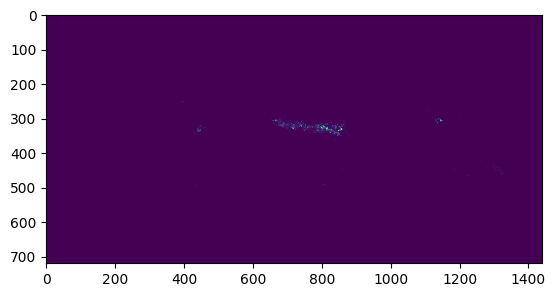

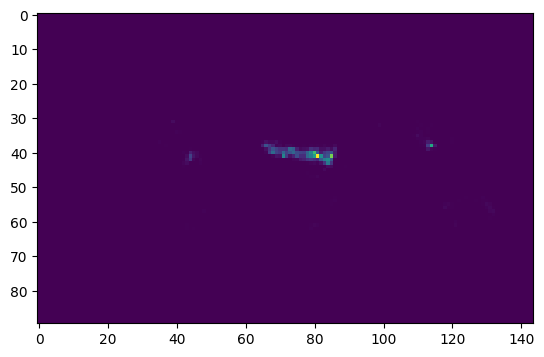


Original Burned Area Total - 181858336768.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 175403.484375
Upscale Burned Area Total - 181858271232.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 175403.484375



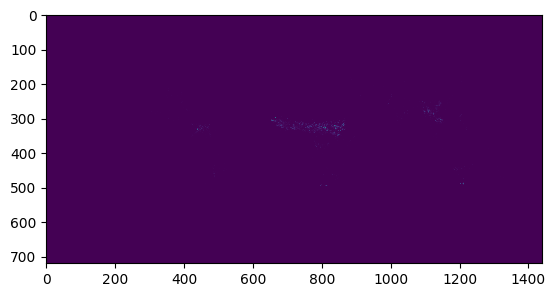

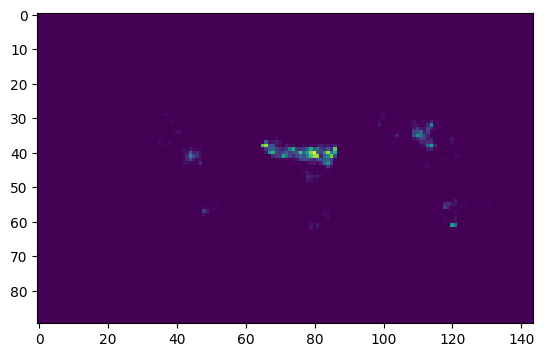


Original Burned Area Total - 175311814656.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 169089.328125
Upscale Burned Area Total - 175311781888.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 169089.328125



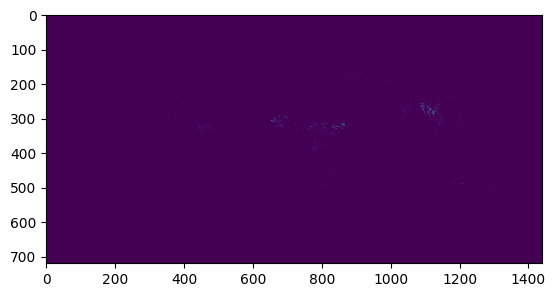

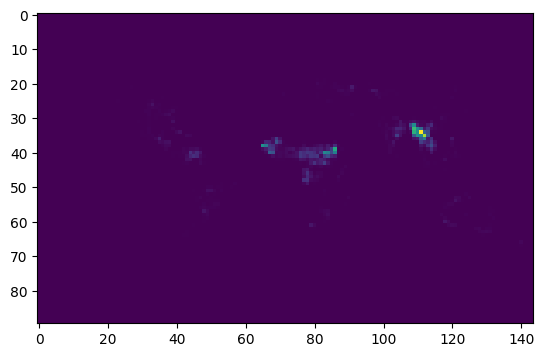


Original Burned Area Total - 128418152448.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 123860.1015625
Upscale Burned Area Total - 128418160640.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 123860.1015625



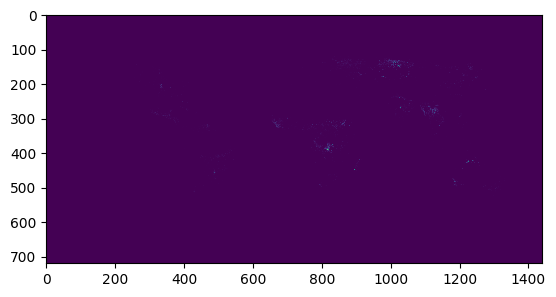

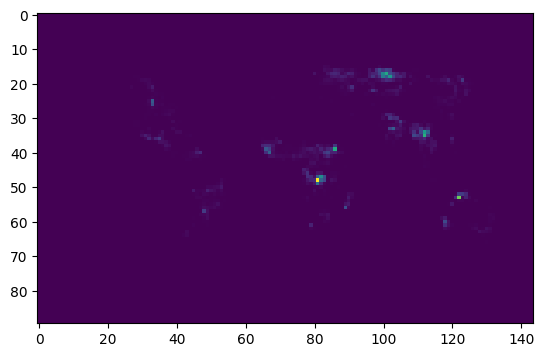


Original Burned Area Total - 175040135168.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 168827.296875
Upscale Burned Area Total - 175040135168.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 168827.296875



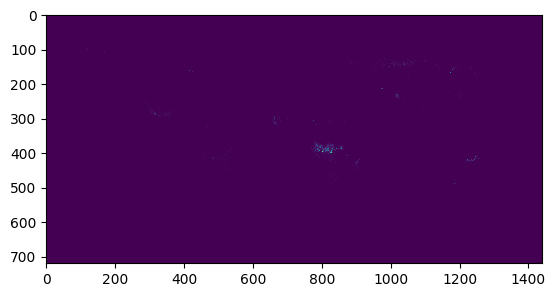

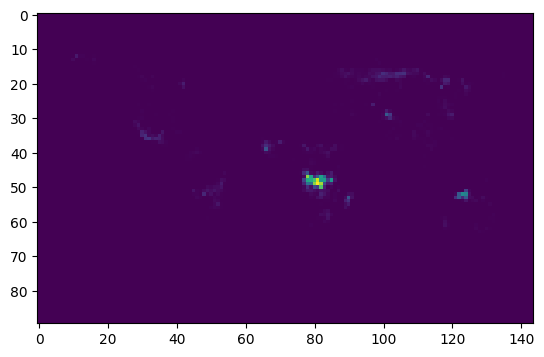


Original Burned Area Total - 372560297984.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 359336.71875
Upscale Burned Area Total - 372560297984.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 359336.71875



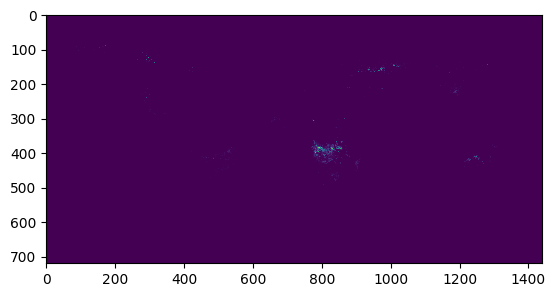

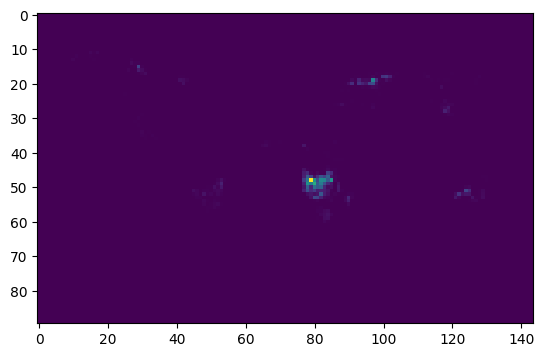


Original Burned Area Total - 507196571648.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 489194.21875
Upscale Burned Area Total - 507196637184.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 489194.21875



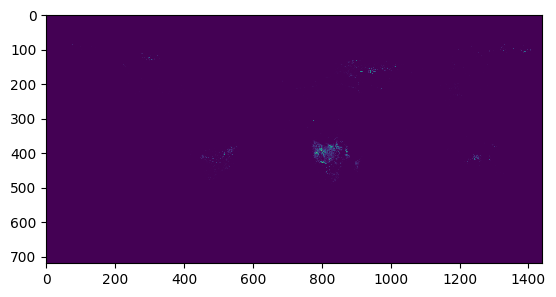

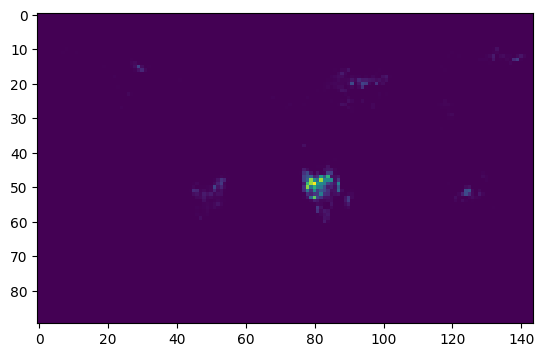


Original Burned Area Total - 710349357056.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 685136.3125
Upscale Burned Area Total - 710349488128.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 685136.3125


Original Burned Area Total - 652866617344.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 629693.875
Upscale Burned Area Total - 652866748416.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 629693.875


Original Burned Area Total - 346284425216.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 333993.46875
Upscale Burned Area Total - 346284457984.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 333993.46875



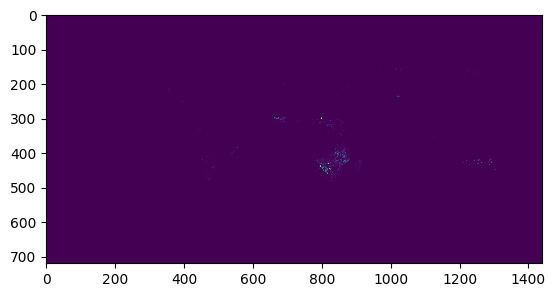

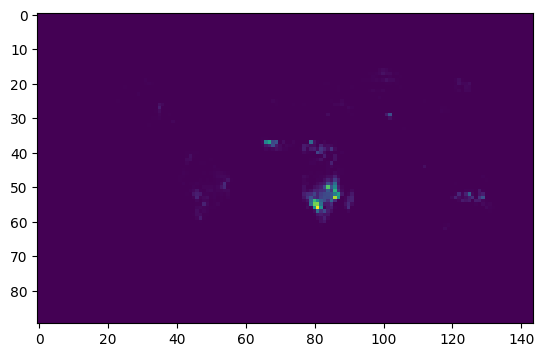


Original Burned Area Total - 336189423616.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 324256.78125
Upscale Burned Area Total - 336189390848.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 324256.78125



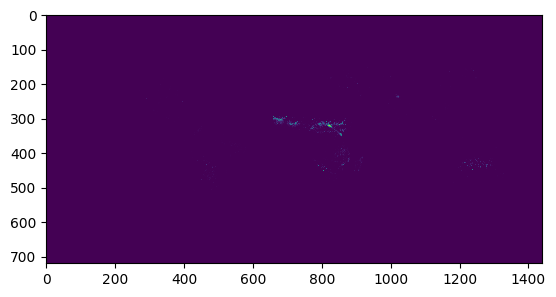

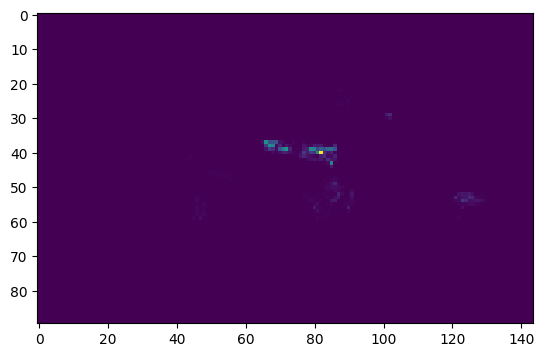


Original Burned Area Total - 489050013696.0
	Original Burned Area Dimensions - (720, 1440)
	Original Burned Area Mean - 471691.75
Upscale Burned Area Total - 489050046464.0
	Upscale Burned Area Dimensions - (90, 144)
	Upscale Burned Area Mean - 471691.75



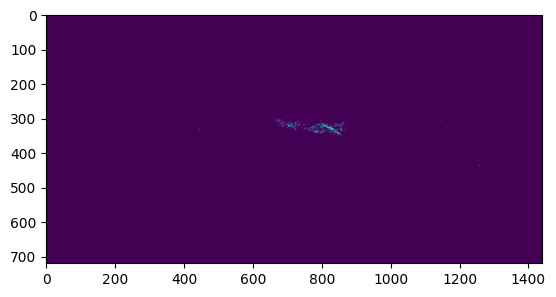

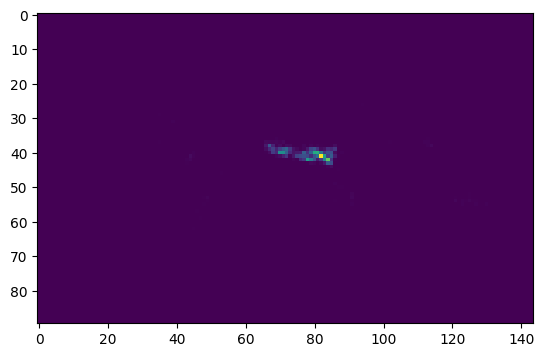

[+] file ./GFED4\upscale\GFED4.1s_2010(upscaled).nc saved


In [48]:
# upscale_density_data()
# upscale_burned_area_data()
# upscale_wglc_data() // further work/analysis  needs to be done on this program and dataset
upscale_gfed4_data()